<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/SuperResolutionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'super-resolution-benchmarks:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2507957%2F4276037%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240715%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240715T150055Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7337f17f85b3ec651b08354d88fa06ebb406fd69b1d1f8040130ea1c09aa4efb2112fda1fc4e743ee63724ab4005b4fb0d0a756d93dabecdaa771d2d9317953a83c4cc00c16d4c50ab0ee5918c9d273c188f828f633fe69c139f3d50fd4b37919b02df6afb87b65ed75aeae8e249fcaca6545be8af748fd036dc0935b6ea5beec8b5849aee9eb630dcae726db0a479529ee4390d7b3f763cf0abba862c8e0952f9110d53ca3df8859ef336c29a9ad239c7b18899e5a9b39bb343be4a8d35c6b6ea94f26d666bdcc884b5f0977277887c9cc38415629a626721fbb0eb9010b138ae9c806cfec6dacdffbe78011fbc71b62a0bc088ad9c951e71c016a1ae973519,football-player-detection-yolov8:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5043911%2F8461408%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240715%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240715T150055Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3103bd4f17f41cb1a4d727a4832d3a2e726d9738819928505b93a11eba0c671cf7e932203fe32662f91524feeed8cb9c74f475659030e38a0463d12da3c7aab5c39972dce0fd3fa527dda67fd375a51729f0b8f807aab08aa5948b47be9b8b6a635b4e43f0f4063574bbb0ab54086ddef2a5ba2d90bd16a557b584193ecb8c7841e468d0e240046ce2f0c37683046b136ab14119edbf683ed4c10758a09016b105e374d8738dba8299a9464e4bbdf41590b76b4f164c4a5d5b31ea9ea7e7039775c6ec6b922c72414476ccf0edbec032bd1ac367fc3bed4761bd6f1009cac58fec502bba11f025ee8828c0e8771326a195dc5bf7a8271d20bfd263a02c59bc63,div-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5392039%2F8958787%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240715%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240715T150055Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D211a0bc4a5d49d6573f964d7db7c350519bbdeb9a7a4e72102dcbed0dd3fb56e83cae75d19d5a50b2a7042c3de19b06201ae823c6a92e84b048fcb7b1b183c6c57449ced6a7a37dea8cde4115a65f6352fa701cc5dda8f3660b868b4cfe3e7b9534e364ab62e905b9a8b13411a6a3d6898d2d4d6a2daf90412f4e39d9d8e9c4c4d7a7e162b5d3abdb0ca3ecc68d9530998d4043648717bdb544462551d33caf744a2944c6f381f8b71e05be5c0abe09c55a742e9d0a5795e22cf6130d0ff8245373b5ba45eceb765395f4d7cf425e5b3c505f2777ea1d3ce4a73aa11517ea9c39558900438046e85f38deb068620ce91883c717821bf32809e9ede4aa2633b52'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 967921789 bytes downloaded
Downloaded and uncompressed: super-resolution-benchmarks
[==================================================] 1164450085 bytes downloaded
Downloaded and uncompressed: football-player-detection-yolov8
[==================================================] 450272196 bytes downloaded
Downloaded and uncompressed: div-images
Data source import complete.


In [2]:
import os
from PIL import Image
from torchvision import transforms
import torch

#------------------------
# データローダー
#------------------------
class DIV2KDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir_low: str, data_dir_high: str, target_size=(380, 510)) -> None:
        super().__init__()
        self.data_dir_low = data_dir_low
        self.data_dir_high = data_dir_high
        self.image_files = [f for f in os.listdir(data_dir_low) if os.path.isfile(os.path.join(data_dir_low, f))]

        # 低画質画像用の変換（指定されたサイズにリサイズ）
        self.transform_low = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor()
        ])

        # 高画質画像用の変換（ターゲットサイズの4倍にリサイズ）
        high_target_size = (target_size[0] * 4, target_size[1] * 4)
        self.transform_high = transforms.Compose([
            transforms.Resize(high_target_size),
            transforms.ToTensor()
        ])

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(self, idx):
        file_id = os.path.splitext(self.image_files[idx])[0]  # 'id' from 'id.jpg'
        low_path = os.path.join(self.data_dir_low, file_id + '.jpg')
        high_path = os.path.join(self.data_dir_high, file_id + '.png')

        low_image = Image.open(low_path).convert("RGB")
        high_image = Image.open(high_path).convert("RGB")

        low_image_tensor = self.transform_low(low_image)
        high_image_tensor = self.transform_high(high_image)

        return low_image_tensor, high_image_tensor

In [3]:
# 画像ディレクトリのパスを設定
train_dir_low = "../input/div-images/DIV2K/train/low"
train_dir_high = "../input/div-images/DIV2K/train/hight"
val_dir_low = "../input/div-images/DIV2K/val/low"
val_dir_high = "../input/div-images/DIV2K/val/hight"

# トレーニング用データセット（通常サイズ）
train_set = DIV2KDataset(train_dir_low, train_dir_high)

# 検証用データセット（4倍のサイズ）
val_set = DIV2KDataset(val_dir_low, val_dir_high)

In [4]:
from torch.utils.data import DataLoader

# データローダーを設定
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False, num_workers=4)

# データの一部を確認
for low, high in train_loader:
    print("Low quality batch shape:", low.shape)
    print("High quality batch shape:", high.shape)
    break  # 一つのバッチだけ表示して停止

Low quality batch shape: torch.Size([4, 3, 380, 510])
High quality batch shape: torch.Size([4, 3, 1520, 2040])


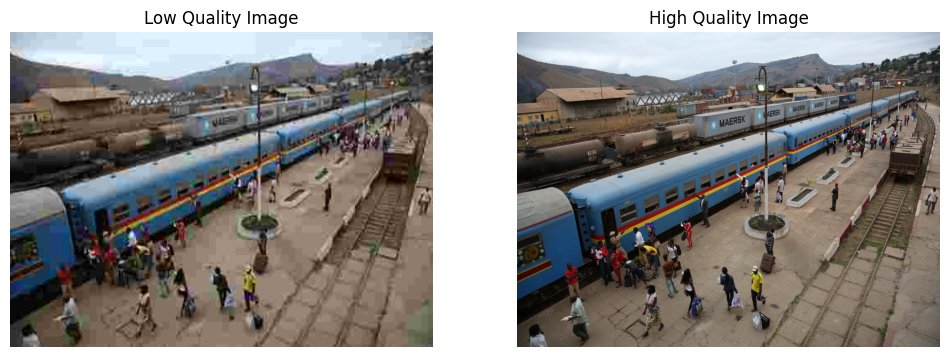

In [5]:
# 読み込み画像の再構築
import matplotlib.pyplot as plt

# Convert the tensors to numpy for plotting
low_np = low[0].permute(1, 2, 0).numpy()  # CHW to HWC and convert to numpy
high_np = high[0].permute(1, 2, 0).numpy()  # CHW to HWC and convert to numpy

# Create subplot to show images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(low_np)
ax[0].set_title('Low Quality Image')
ax[0].axis('off')

ax[1].imshow(high_np)
ax[1].set_title('High Quality Image')
ax[1].axis('off')

plt.show()

In [6]:
# cleate model
import torch
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self, upscale_factor=4) -> None:
        super().__init__()
        self.upscale_factor = upscale_factor
        self.block = nn.Sequential(
            nn.Upsample(scale_factor=self.upscale_factor, mode='bilinear', align_corners=False),
            nn.Conv2d(3, 64, kernel_size=9, padding=4),  # padding=(kernel_size-1)/2
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=5, padding=2)   # padding=(kernel_size-1)/2
        )

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        output = self.block(image)
        return output

# モデルのインスタンスを作成
model = SRCNN()

# ダミーの入力データ (例: バッチサイズ=1, チャンネル=3, 高さ=256, 幅=256)
dummy_input = torch.randn(1, 3, 256, 256)

# モデルを通して出力を得る
output = model(dummy_input)

print("Output shape:", output.shape)

Output shape: torch.Size([1, 3, 1024, 1024])


In [10]:
#PSNRの計算
import torch
import torch.nn.functional as F

def PSNR(pred, target, max_val=1.0):
    mse = F.mse_loss(pred, target, reduction='mean')  # 確実にテンソルを返すように
    if mse == 0:
        return torch.tensor(float('inf'))
    return 20 * torch.log10(torch.tensor(max_val)) - 10 * torch.log10(mse)


In [8]:
epochs = 20
device = "cuda:0"
lr = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)

SRCNN(
  (block): Sequential(
    (0): Upsample(scale_factor=4.0, mode='bilinear')
    (1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [11]:
import numpy as np

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_psnr, val_loss, val_psnr = [], [], [], []

    # トレーニングフェーズ
    model.train()
    for low, high in train_loader:
        low, high = low.to(device), high.to(device)

        optimizer.zero_grad()
        pred = model(low)

        loss = nn.MSELoss()(pred, high)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        psnr = PSNR(pred, high)
        train_psnr.append(psnr.item())

    # 評価フェーズ
    model.eval()
    with torch.no_grad():
        for low, high in val_loader:
            low, high = low.to(device), high.to(device)
            pred = model(low)

            loss = nn.MSELoss()(pred, high)
            val_loss.append(loss.item())
            val_psnr.append(PSNR(pred, high).item())

    # エポックごとの結果表示
    print(f"Train Loss: {np.mean(train_loss):.4f}, Train PSNR: {np.mean(train_psnr):.2f}")
    print(f"Val Loss: {np.mean(val_loss):.4f}, Val PSNR: {np.mean(val_psnr):.2f}")

Epoch 1/20
Train Loss: 0.0328, Train PSNR: 15.68
Val Loss: 0.0189, Val PSNR: 17.38
Epoch 2/20
Train Loss: 0.0128, Train PSNR: 19.15
Val Loss: 0.0101, Val PSNR: 20.14
Epoch 3/20
Train Loss: 0.0084, Train PSNR: 20.97
Val Loss: 0.0090, Val PSNR: 20.66
Epoch 4/20
Train Loss: 0.0078, Train PSNR: 21.22
Val Loss: 0.0080, Val PSNR: 21.15
Epoch 5/20
Train Loss: 0.0076, Train PSNR: 21.39
Val Loss: 0.0078, Val PSNR: 21.28
Epoch 6/20
Train Loss: 0.0072, Train PSNR: 21.67
Val Loss: 0.0074, Val PSNR: 21.52
Epoch 7/20
Train Loss: 0.0069, Train PSNR: 21.79
Val Loss: 0.0075, Val PSNR: 21.48
Epoch 8/20
Train Loss: 0.0068, Train PSNR: 21.88
Val Loss: 0.0069, Val PSNR: 21.84
Epoch 9/20
Train Loss: 0.0067, Train PSNR: 22.12
Val Loss: 0.0071, Val PSNR: 21.72
Epoch 10/20
Train Loss: 0.0067, Train PSNR: 21.96
Val Loss: 0.0071, Val PSNR: 21.70
Epoch 11/20
Train Loss: 0.0066, Train PSNR: 21.94
Val Loss: 0.0068, Val PSNR: 21.94
Epoch 12/20
Train Loss: 0.0066, Train PSNR: 22.11
Val Loss: 0.0067, Val PSNR: 21.96
E

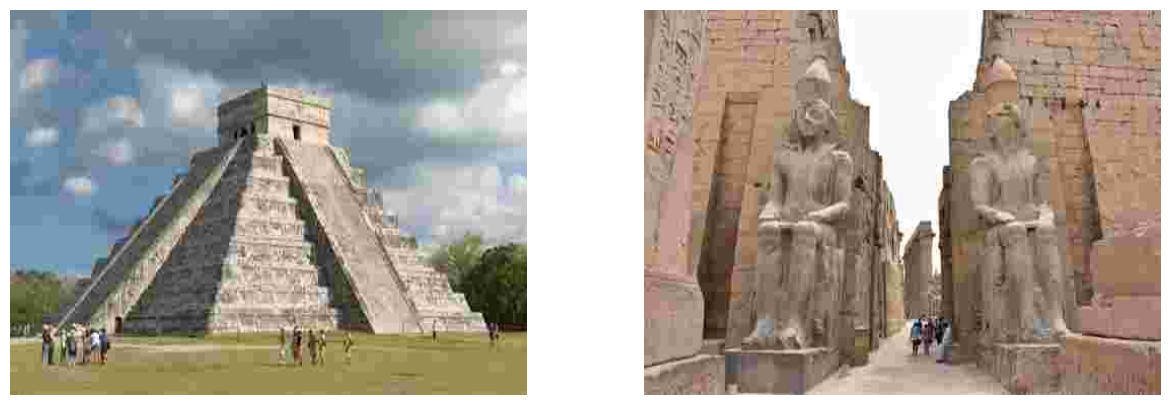

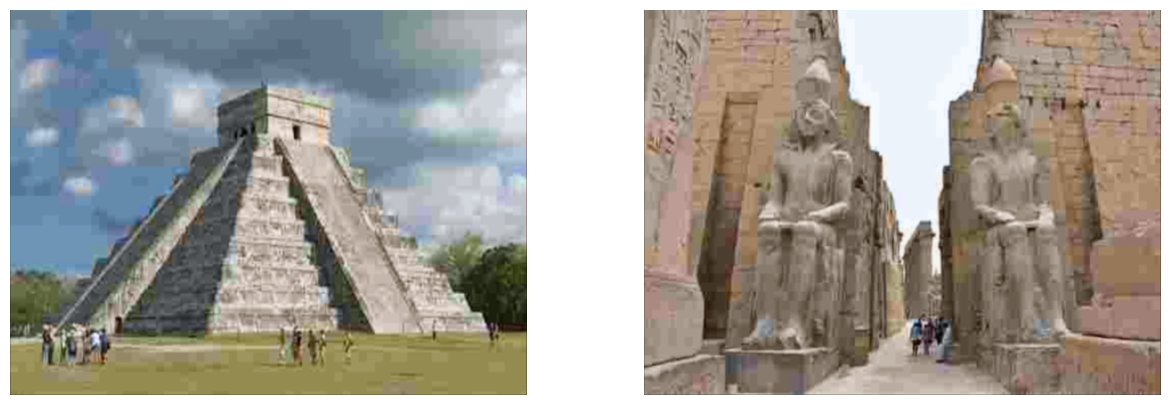

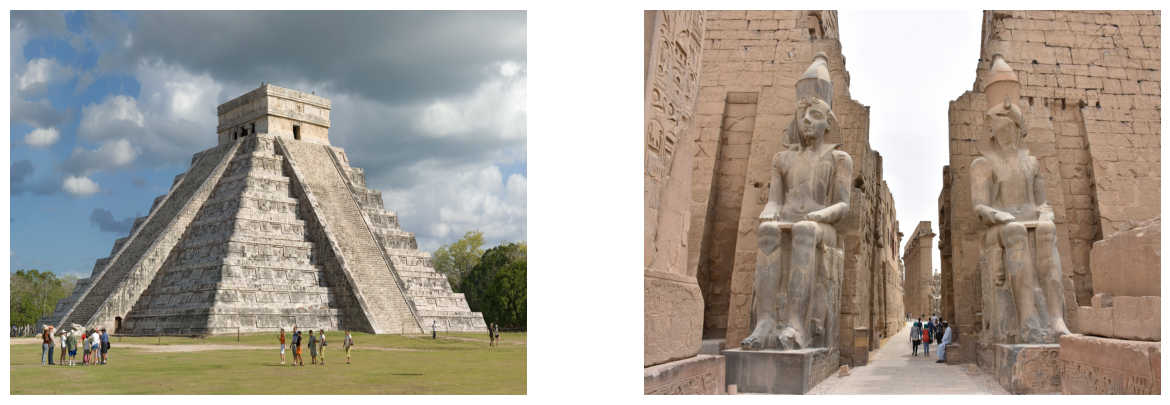

In [15]:
# 結果を表示する関数
def show_images(images, num_images=2):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes.flat):
        img = images[i].detach()  # テンソルから画像データを取得
        img = img.permute(1, 2, 0)  # チャンネルを最後に移動
        img = img.numpy()
        img = np.clip(img, 0, 1)  # 画像データを[0, 1]にクリップ
        ax.imshow(img)
        ax.axis('off')  # 軸をオフに
    plt.show()

# モデルを評価モードに設定
model.eval()

# 検証データから1バッチ分取得し、予測を行う
with torch.no_grad():
    for low_res, high_res in val_loader:
        low_res = low_res.to(device)
        preds = model(low_res).cpu()  # 予測結果をCPUに移動
        break  # 最初のバッチのみ処理

# 低解像度、高解像度（真実）、予測画像を表示
show_images(low_res.cpu(), num_images=2)  # 低解像度画像
show_images(preds, num_images=2)  # 予測された高解像度画像
show_images(high_res.cpu(), num_images=2)  # 真実の高解像度画像